# Project 2

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeClassifier

In [15]:
import os
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import seaborn as sns  

In [17]:
df = pd.read_csv('data/glass.data', header=None)

# Name columns
df = df.rename(columns={0: 'Id', 1: 'RI', 2: 'Na', 3: 'Mg', 4: 'Al', 5: 'Si', 6: 'K', 7: 'Ca', 8: 'Ba', 9: 'Fe', 10: 'Type'})
# Change type of 'Type' to categorical
df['Type'] = df['Type'].astype('category')
# df['Type'] = df['Type'].cat.rename_categories({ 1: 'building_windows_float_processed',
#                                                 2: 'building_windows_non_float_processed',
#                                                 3: 'vehicle_windows_float_processed',
#                                                 4: 'vehicle_windows_non_float_processed',
#                                                 5: 'containers',
#                                                 6: 'tableware',
#                                                 7: 'headlamps'})
df['Type'] = df['Type'].cat.rename_categories({ 1: 'BW-FP',
                                                2: 'BW-NFP',
                                                3: 'VW-FP',
                                                4: 'VW-NFP',
                                                5: 'containers',
                                                6: 'tableware',
                                                7: 'headlamps'})

In [38]:
# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 1. Regression

The initial plan was to predict $y = \texttt{RI}$ based on the chemical composition of the glass and the glass type (standardized $\tilde{\mathbf{X}}$).

<b style="color:red;">However, it turns out that:</b>

1. By including `Type` as a predictor, the model is able to perfectly predict `RI`. This is because the types of glass have distinct refractive indices, allowing the model to leverage this categorical information to achieve perfect predictions.

2. Even without `Type`, we can still achieve mega low errors (MSE < 0.0001) using only the chemical composition features. This suggests that the chemical composition alone is highly predictive of the refractive index, allowing for very accurate predictions without needing to consider the glass type.

<b style="color:red">Therefore, we have two choices:</b>

1. Predict `RI` using all chemical elements except `Type` (i.e., $\tilde{\mathbf{X}}$ without `Type`).
2. Predict a specific chemical element (e.g., `Na`) using all other chemical elements
    1. With `Type`
    2. Without `Type`

### Part a)

In [64]:
X_r = df.drop(columns=['Id', 'Type'])  # Features
# X_r = df.drop(columns=['Id', 'RI'])  # Features
y_r = df['RI']
y_r = y_r.astype('float64')

# Transform Type into one-of-K encoding
# X_r = pd.get_dummies(X_r, columns=['Type'], prefix='Type')

# We will use regularization, so we need to standardize the data
X_r = (X_r - X_r.mean(axis=0))                  # Centering
X_r = X_r / X_r.std(axis=0, ddof=1)             # Standardization with unbiased estimator (N-1 in denominator)

# ! Do we need to standardize the one-of-K encoding columns?
# I think so, because they are also features, and regularization will be applied to them as well.
# However, standardizing one-of-K encoding columns will make them no longer binary (0 or 1).
# This is not a problem for regularization, but it might be a problem for interpretability.

# print the first few rows of the modified dataframe
print(X_r.head())
# print the y variable
print(y_r.head())

         RI        Na        Mg        Al        Si         K        Ca  \
0  0.870826  0.284287  1.251704 -0.690822 -1.124446 -0.670134 -0.145425   
1 -0.248750  0.590433  0.634680 -0.170061  0.102080 -0.026152 -0.791877   
2 -0.719631  0.149582  0.600016  0.190465  0.437760 -0.164148 -0.827010   
3 -0.232286 -0.242285  0.697076 -0.310266 -0.052850  0.111844 -0.517838   
4 -0.311315 -0.168810  0.648546 -0.410413  0.553957  0.081178 -0.623237   

         Ba        Fe  
0 -0.352051 -0.585079  
1 -0.352051 -0.585079  
2 -0.352051 -0.585079  
3 -0.352051 -0.585079  
4 -0.352051 -0.585079  
0    1.52101
1    1.51761
2    1.51618
3    1.51766
4    1.51742
Name: RI, dtype: float64


Lambda: 0.0001, MSE: 2.542522472981226e-17
Lambda: 0.00014563484775012445, MSE: 5.3922848189153067e-17
Lambda: 0.00021209508879201905, MSE: 1.143590553362578e-16
Lambda: 0.00030888435964774815, MSE: 2.425232136311984e-16
Lambda: 0.0004498432668969444, MSE: 5.142973519336584e-16
Lambda: 0.0006551285568595509, MSE: 1.0905450297360277e-15
Lambda: 0.0009540954763499944, MSE: 2.3122082509998576e-15
Lambda: 0.0013894954943731374, MSE: 4.90166496777138e-15
Lambda: 0.0020235896477251557, MSE: 1.0388762349704994e-14
Lambda: 0.0029470517025518097, MSE: 2.2011251454145574e-14
Lambda: 0.004291934260128779, MSE: 4.661497695646199e-14
Lambda: 0.0062505519252739694, MSE: 9.865523647395258e-14
Lambda: 0.009102981779915217, MSE: 2.0859766871585063e-13
Lambda: 0.013257113655901081, MSE: 4.4048516547953244e-13
Lambda: 0.019306977288832496, MSE: 9.284794061602513e-13
Lambda: 0.02811768697974228, MSE: 1.952380719101929e-12
Lambda: 0.040949150623804234, MSE: 4.0925546307154644e-12
Lambda: 0.0596362331659464

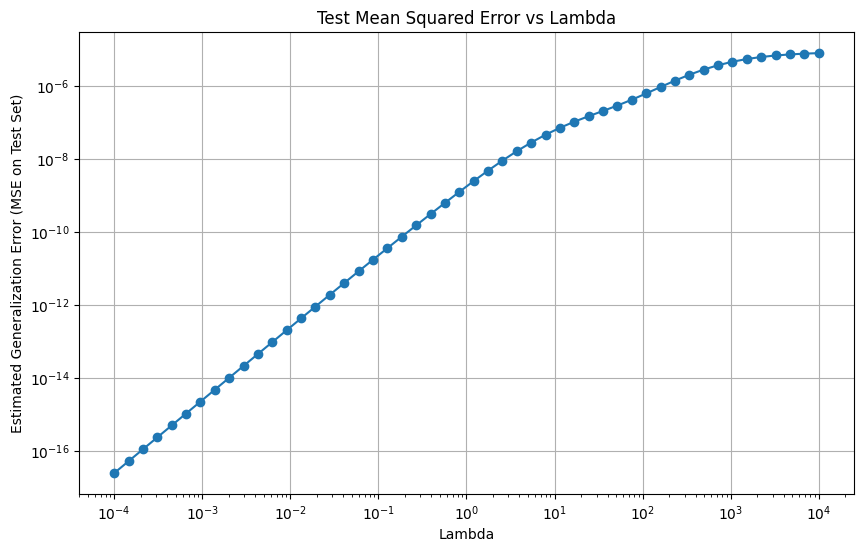

Best lambda: 0.0001 with MSE: 2.542522472981226e-17


In [ ]:
lambdas = np.logspace(-4, 4, 50)  # Regularization parameters to try

# 10-fold cross-validation for regression
ten_fold = KFold(n_splits=10, shuffle=True, random_state=42)
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

MSEs = []

# Training loop
for l in lambdas:
    model = Ridge(alpha=l)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = np.mean((y_test - y_pred) ** 2)
    MSEs.append(MSE)
    print(f'Lambda: {l}, MSE: {MSE}')

# Plot MSE vs lambda
plt.figure(figsize=(10, 6))
plt.plot(lambdas, MSEs, marker='o')
plt.xlabel('Lambda')
plt.ylabel('Estimated Generalization Error (MSE on Test Set)')
plt.title('Test Mean Squared Error vs Lambda')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.savefig('ridge_regression_mse_vs_lambda.png')
plt.show()

# Find the best lambda
best_lambda = lambdas[np.argmin(MSEs)]
print(f'Best lambda: {best_lambda} with MSE: {min(MSEs)}')

# ! -> Turns out that we don't need regularization at all when predicting RI, as the best lambda is very close to 0.

### Part b)

We will compare three models: 
1. the regularized linear regression model from the previous section
2. an artificial neural network (ANN)
3. a baseline model

We are interested in two questions: Is one model better than the other? Is either model better than a trivial baseline? We will attempt to answer these questions with **two-level cross-validation**.

The baseline model is the mean predictor, which always predicts the mean of the training set.

#### Regularized linear regression

In [68]:
# Hyperparameters
lambdas = np.linspace(0.01, 3, 20)
hidden_units = [2, 10, 64, 128, 256, 512]
MAX_ITER = 5000

# K-fold cross-validation
K1 = 10  # Outer folds
K2 = 10  # Inner folds
outer_kf = KFold(n_splits=K1, shuffle=True, random_state=RANDOM_SEED)

# Initialize lists to store the errors and best hyperparameters for each outer fold
results = {
    'i': [],
    'h_star': [],
    'E_ann': [],
    'lambda_star': [],
    'E_rlr': [],
    'E_baseline': []
}

# Outer loop to select model and hyperparameters
for i, (train_index, test_index) in enumerate(outer_kf.split(X_r, y_r)):


    fold_i = i + 1
    
    # Split data
    # => D_i^train, D_i^test
    X_train_outer, y_train_outer = X_r.iloc[train_index], y_r.iloc[train_index]
    X_test_outer, y_test_outer = X_r.iloc[test_index], y_r.iloc[test_index]
    
    # Store fold index
    results['i'].append(fold_i)


    # Inner loops to estimate hyperparameters and errors

    
    # ------------------------------------------------------
    # --- Inner loop for Regularized Linear Regression ---
    # ------------------------------------------------------
    inner_kf_rlr = KFold(n_splits=K2, shuffle=True, random_state=RANDOM_SEED)
    E_val_rlr = np.zeros(len(lambdas))
    
    # Train one model for each lambda...
    for j, l in enumerate(lambdas):

        E_val_inner = []

        # ... and for each inner fold split
        for train_inner_index, val_inner_index in inner_kf_rlr.split(X_train_outer, y_train_outer):

            X_train_inner, y_train_inner = X_train_outer.iloc[train_inner_index], y_train_outer.iloc[train_inner_index]
            X_val_inner, y_val_inner = X_train_outer.iloc[val_inner_index], y_train_outer.iloc[val_inner_index]
            
            model = Ridge(alpha=l)
            model.fit(X_train_inner, y_train_inner)
            y_pred_val = model.predict(X_val_inner)
            E_val_inner.append(np.mean((y_val_inner.values - y_pred_val)**2))

        E_val_rlr[j] = np.mean(E_val_inner)
        
    # Find best lambda based on the E_val's and store it
    best_lambda = lambdas[np.argmin(E_val_rlr)]
    results['lambda_star'].append(best_lambda)
    
    # Train RLR model on outer train set D_i^train with best lambda
    final_model_rlr = Ridge(alpha=best_lambda)
    final_model_rlr.fit(X_train_outer, y_train_outer)
    y_pred_rlr = final_model_rlr.predict(X_test_outer)

    # Compute E_i^test = (1/N^test) * sum (y_n - y_pred_n)^2
    E_test_rlr = np.mean((y_test_outer.values - y_pred_rlr)**2)

    # Store test error = estimated generalization error
    results['E_rlr'].append(E_test_rlr)


    # -----------------------------
    # --- Inner loop for ANN ---
    # -----------------------------

    inner_kf_ann = KFold(n_splits=K2, shuffle=True, random_state=RANDOM_SEED)
    E_val_ann = np.zeros(len(hidden_units))

    # Train one model for each number of hidden units...
    for j, h in enumerate(hidden_units):

        E_val_inner = []

        # ... and for each inner fold split
        for train_inner_index, val_inner_index in inner_kf_ann.split(X_train_outer, y_train_outer):

            # Split data
            # => D_i^train, D_i^val
            X_train_inner, y_train_inner = X_train_outer.iloc[train_inner_index], y_train_outer.iloc[train_inner_index]
            X_val_inner, y_val_inner = X_train_outer.iloc[val_inner_index], y_train_outer.iloc[val_inner_index]

            model = MLPRegressor(hidden_layer_sizes=(h,), max_iter=MAX_ITER, random_state=RANDOM_SEED)
            model.fit(X_train_inner, y_train_inner)
            y_pred_val = model.predict(X_val_inner)

            E_val_inner.append(np.mean((y_val_inner.values - y_pred_val)**2))

        E_val_ann[j] = np.mean(E_val_inner)

    # Find best number of hidden units
    best_h = hidden_units[np.argmin(E_val_ann)]
    results['h_star'].append(best_h) # Store best hyperparameter

    # Train ANN model on outer train set with best h
    final_model_ann = MLPRegressor(hidden_layer_sizes=(best_h,), max_iter=MAX_ITER, random_state=RANDOM_SEED)
    final_model_ann.fit(X_train_outer, y_train_outer)
    y_pred_ann = final_model_ann.predict(X_test_outer)

    # Compute E_i^test = (1/N^test) * sum (y_n - y_pred_n)^2
    E_test_ann = np.mean((y_test_outer.values - y_pred_ann)**2)

    # Store test error
    results['E_ann'].append(E_test_ann)


    # ----------------------
    # --- Baseline model ---
    # ----------------------

    baseline_pred = y_train_outer.mean()
    E_test_baseline = np.mean((y_test_outer.values - baseline_pred)**2)
    results['E_baseline'].append(E_test_baseline) 

# Convert results to a DataFrame for easier handling
results_df = pd.DataFrame(results)

In [80]:
def generate_latex_table_content(df):
    """
    Generates only the data content rows and final \hline for the LaTeX table.
    Uses 5 significant figures for errors (scientific notation) and 3 for lambda.
    """
    
    latex_code = ""
    
    # Data rows
    for index, row in df.iterrows():
        i = int(row['i'])
        h_star = int(row['h_star'])
        
        # Errors: 5 significant figures using scientific notation (e.g., 1.2345e-02)
        E_ann = f"\\SI{{ {row['E_ann']:.3e} }}{{}}"
        E_rlr = f"\\SI{{ {row['E_rlr']:.3e} }}{{}}"
        E_baseline = f"\\SI{{ {row['E_baseline']:.3e} }}{{}}"

        # Lambda: 3 significant figures (general format)
        lambda_star = f"\\SI{{ {row['lambda_star']:.3g} }}{{}}"
        
        # Assemble the row
        row_str = f"{i} & {h_star} & {E_ann} & {lambda_star} & {E_rlr} & {E_baseline} \\\\ \n"
        latex_code += row_str
        
    return latex_code

In [82]:
latex_table_content_output = generate_latex_table_content(results_df)
print(latex_table_content_output)

1 & 128 & \SI{ 2.847e-02 }{} & \SI{ 0.01 }{} & \SI{ 9.516e-14 }{} & \SI{ 9.893e-06 }{} \\ 
2 & 128 & \SI{ 1.572e-02 }{} & \SI{ 0.01 }{} & \SI{ 3.239e-13 }{} & \SI{ 7.295e-06 }{} \\ 
3 & 128 & \SI{ 7.582e-02 }{} & \SI{ 0.01 }{} & \SI{ 7.883e-13 }{} & \SI{ 7.229e-06 }{} \\ 
4 & 256 & \SI{ 1.983e-02 }{} & \SI{ 0.01 }{} & \SI{ 1.095e-13 }{} & \SI{ 8.142e-06 }{} \\ 
5 & 128 & \SI{ 2.452e-02 }{} & \SI{ 0.01 }{} & \SI{ 2.309e-13 }{} & \SI{ 3.843e-06 }{} \\ 
6 & 128 & \SI{ 2.165e-02 }{} & \SI{ 0.01 }{} & \SI{ 1.261e-13 }{} & \SI{ 4.273e-06 }{} \\ 
7 & 128 & \SI{ 1.983e-02 }{} & \SI{ 0.01 }{} & \SI{ 4.525e-13 }{} & \SI{ 8.609e-06 }{} \\ 
8 & 128 & \SI{ 1.222e-02 }{} & \SI{ 0.01 }{} & \SI{ 1.560e-13 }{} & \SI{ 1.072e-05 }{} \\ 
9 & 256 & \SI{ 5.593e-02 }{} & \SI{ 0.01 }{} & \SI{ 6.452e-13 }{} & \SI{ 1.782e-05 }{} \\ 
10 & 256 & \SI{ 9.549e-02 }{} & \SI{ 0.01 }{} & \SI{ 7.505e-14 }{} & \SI{ 1.526e-05 }{} \\ 



## 2. Classification

We use the standardized data $\tilde{\mathbf{X}}$, which has the refractive index (`RI` column) and oxide contents (`Na`, `Mg`, `Al`, `Si`, `K`, `Ca`, `Ba`, `Fe` columns), to predict the glass type (`Type` column)

So, we have $$\tilde{\mathbf{X}} \in \mathbb{R}^{214 \times 9}$$ and $$\mathbf{y} \in \{1, 2, 3, 5, 6\}^{214}$$

1. This is a **multi-class classification** problem
2. We will compare logistic regression, *method 2* and a baseline. The baseline predicts the most frequent class in the training set for all test samples.

<b style="color:red;">TODO: choose <i>one</i> of the following options for <i>method 2</i>:</b>

1. ANN (hyperparameter: number of hidden units $h$)
2. Classification trees (same complexity controller parameter as regression trees)
3. KNN (hyperparameter: number of neighbors $k$)
4. Naive Bayes (hyperparameter $b$)

In [72]:
X_c = df.drop(columns=['Id', 'Type'])
y_c = df['Type']

# Encode labels
le = LabelEncoder()
y_c = le.fit_transform(y_c)

### Training loop

In [ ]:
# Hyperparameters
# Logistic Regression complexity is controlled by C, which is 1/lambda.
# Small C (large lambda) = Strong regularization. We use C=1/lambda.
C_values = np.logspace(-3, 3, 20) 
# Classification Tree max depths
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]

# K-fold cross-validation setup
K1 = 10  # Outer folds
K2 = 10  # Inner folds
outer_kf = KFold(n_splits=K1, shuffle=True, random_state=42)

# Initialize storage for results
results_cls = {
    'i': [],
    'd_star': [],        # Best max_depth for Tree
    'E_tree': [],        # Test Error for Tree
    'C_star': [],        # Best C (1/lambda) for LogReg
    'E_logreg': [],      # Test Error for LogReg
    'E_baseline': []     # Test Error for Baseline
}

# Outer loop
for i, (train_index, test_index) in enumerate(outer_kf.split(X_c, y_c)):
    fold_i = i + 1
    
    # Split data
    X_train_outer, y_train_outer = X_c.iloc[train_index], y_c[train_index]
    X_test_outer, y_test_outer = X_c.iloc[test_index], y_c[test_index]
    
    results_cls['i'].append(fold_i)
    
    # ----------------------------------------------------
    # --- Inner loop for Regularized Logistic Regression ---
    # ----------------------------------------------------
    inner_kf_logreg = KFold(n_splits=K2, shuffle=True, random_state=42)
    E_val_logreg = np.zeros(len(C_values))
    
    for j, C_val in enumerate(C_values):
        E_val_inner = []
        for train_inner_index, val_inner_index in inner_kf_logreg.split(X_train_outer, y_train_outer):
            X_train_inner, y_train_inner = X_train_outer.iloc[train_inner_index], y_train_outer[train_inner_index]
            X_val_inner, y_val_inner = X_train_outer.iloc[val_inner_index], y_train_outer[val_inner_index]
            
            # Logistic Regression: penalty='l2' (Ridge), C is complexity (1/lambda)
            model = LogisticRegression(C=C_val, penalty='l2', solver='liblinear', max_iter=5000, random_state=42)
            model.fit(X_train_inner, y_train_inner)
            y_pred_val = model.predict(X_val_inner)
            # Error = Misclassification Rate = 1 - Accuracy
            E_val_inner.append(1 - accuracy_score(y_val_inner, y_pred_val))
        E_val_logreg[j] = np.mean(E_val_inner)
        
    # Find best C value (min error)
    best_C = C_values[np.argmin(E_val_logreg)]
    results_cls['C_star'].append(best_C)
    
    # Train final LogReg model on outer train set with best C
    final_model_logreg = LogisticRegression(C=best_C, penalty='l2', solver='liblinear', max_iter=5000, random_state=42)
    final_model_logreg.fit(X_train_outer, y_train_outer)
    y_pred_logreg = final_model_logreg.predict(X_test_outer)
    E_test_logreg = 1 - accuracy_score(y_test_outer, y_pred_logreg)
    results_cls['E_logreg'].append(E_test_logreg)

    # --------------------------------------------
    # --- Inner loop for Classification Tree ---
    # --------------------------------------------
    inner_kf_tree = KFold(n_splits=K2, shuffle=True, random_state=42)
    E_val_tree = np.zeros(len(max_depths))

    for j, d in enumerate(max_depths):
        E_val_inner = []
        for train_inner_index, val_inner_index in inner_kf_tree.split(X_train_outer, y_train_outer):
            X_train_inner, y_train_inner = X_train_outer.iloc[train_inner_index], y_train_outer[train_inner_index]
            X_val_inner, y_val_inner = X_train_outer.iloc[val_inner_index], y_train_outer[val_inner_index]

            # Decision Tree with max_depth h
            model = DecisionTreeClassifier(max_depth=d, random_state=42)
            model.fit(X_train_inner, y_train_inner)
            y_pred_val = model.predict(X_val_inner)
            E_val_inner.append(1 - accuracy_score(y_val_inner, y_pred_val))
        E_val_tree[j] = np.mean(E_val_inner)

    # Find best max_depth
    best_d = max_depths[np.argmin(E_val_tree)]
    results_cls['d_star'].append(best_d)

    # Train final Tree model on outer train set with best d
    final_model_tree = DecisionTreeClassifier(max_depth=best_d, random_state=42)
    final_model_tree.fit(X_train_outer, y_train_outer)
    y_pred_tree = final_model_tree.predict(X_test_outer)
    E_test_tree = 1 - accuracy_score(y_test_outer, y_pred_tree)
    results_cls['E_tree'].append(E_test_tree)

    # ----------------------------
    # --- Baseline model ---
    # ----------------------------
    # Baseline predicts the most dominant class in the training set
    (unique, counts) = np.unique(y_train_outer, return_counts=True)
    dominant_class = unique[np.argmax(counts)]
    
    baseline_pred = np.full_like(y_test_outer, dominant_class)
    E_test_baseline = 1 - accuracy_score(y_test_outer, baseline_pred)
    results_cls['E_baseline'].append(E_test_baseline)

# Convert results to a DataFrame
results_cls_df = pd.DataFrame(results_cls)

/Users/vincent/anaconda3/envs/DTU_machine-learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/vincent/anaconda3/envs/DTU_machine-learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/vincent/anaconda3/envs/DTU_machine-learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass c

In [92]:
def generate_latex_classification_table_content(df):
    """
    Generates only the data content rows and final \hline for the LaTeX classification table.
    Uses 5 significant figures for errors (scientific notation) and 3 for lambda (1/C).
    """
    
    latex_code = ""
    
    # Data rows
    for index, row in df.iterrows():
        i = int(row['i'])
        d_star = int(row['d_star'])
        
        # Errors (Misclassification Rate): 5 significant figures (e.g., 1.2345e-01)
        E_tree = f"\\SI{{ {row['E_tree']:.5e} }}{{}}"
        E_logreg = f"\\SI{{ {row['E_logreg']:.5e} }}{{}}"
        E_baseline = f"\\SI{{ {row['E_baseline']:.5e} }}{{}}"

        # Hyperparameters: max_depth is integer. lambda_i is 1/C_star, 3 significant figures
        lambda_star = 1 / row['C_star'] 
        lambda_star_str = f"\\SI{{ {lambda_star:.3g} }}{{}}"
        
        # Assemble the row
        # Note: The original table structure and headers must be adapted for these new models.
        # We will follow the format of the previous table columns:
        # i | h_i^* (d_i^*) | E_i^test (ANN/Tree) | lambda_i | E_i^test (RLR/LogReg) | E_i^test (Baseline)
        row_str = f"{i} & {d_star} & {E_tree} & {lambda_star_str} & {E_logreg} & {E_baseline} \\\\ \n"
        latex_code += row_str
        
    # Final \hline
    latex_code += "\\hline"
    
    return latex_code

# Generate and print the LaTeX code content
latex_table_content_output = generate_latex_classification_table_content(results_cls_df)


In [93]:
# Print LaTeX results
latex_table_content_output_cls = generate_latex_classification_table_content(results_cls_df)
print(latex_table_content_output_cls)

1 & 10 & \SI{ 1.36364e-01 }{} & \SI{ 0.001 }{} & \SI{ 2.27273e-01 }{} & \SI{ 6.36364e-01 }{} \\ 
2 & 6 & \SI{ 4.09091e-01 }{} & \SI{ 0.00886 }{} & \SI{ 2.72727e-01 }{} & \SI{ 6.81818e-01 }{} \\ 
3 & 4 & \SI{ 4.54545e-01 }{} & \SI{ 0.00886 }{} & \SI{ 4.09091e-01 }{} & \SI{ 5.90909e-01 }{} \\ 
4 & 4 & \SI{ 5.00000e-01 }{} & \SI{ 0.00886 }{} & \SI{ 4.54545e-01 }{} & \SI{ 5.45455e-01 }{} \\ 
5 & 7 & \SI{ 2.85714e-01 }{} & \SI{ 0.001 }{} & \SI{ 3.33333e-01 }{} & \SI{ 6.19048e-01 }{} \\ 
6 & 10 & \SI{ 4.76190e-01 }{} & \SI{ 0.001 }{} & \SI{ 5.71429e-01 }{} & \SI{ 7.14286e-01 }{} \\ 
7 & 8 & \SI{ 2.85714e-01 }{} & \SI{ 0.00886 }{} & \SI{ 3.33333e-01 }{} & \SI{ 7.14286e-01 }{} \\ 
8 & 5 & \SI{ 1.42857e-01 }{} & \SI{ 0.0183 }{} & \SI{ 2.38095e-01 }{} & \SI{ 6.19048e-01 }{} \\ 
9 & 10 & \SI{ 4.76190e-01 }{} & \SI{ 0.001 }{} & \SI{ 3.33333e-01 }{} & \SI{ 8.57143e-01 }{} \\ 
10 & 3 & \SI{ 4.28571e-01 }{} & \SI{ 0.0183 }{} & \SI{ 4.76190e-01 }{} & \SI{ 8.09524e-01 }{} \\ 
\hline
